Import All Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense,Dropout
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense,Dropout
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import imageio
import math
from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d

Prepare Data from CSV

In [2]:
data = pd.read_csv("merged_datasets.csv",header="infer")
data = data.drop(columns=["HUMAN PLAYER POSITION (X) metres","HUMAN PLAYER POSITION (Y) metres","INITITAL VELOCITY OF SHUTTELCOCK(m/s)","INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)","SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)","OUT_OF_COURT_SHOTS"])
data = data.rename(columns={"SHUTTLECOCK POSITIION IN AIR(X ) metres":"X","SHUTTLECOCK POSITIION IN AIR(Y) metres":"Y","SHUTTLECOCK POSITIION IN AIR(Z) metres":"Z"})

Split Dataset

In [3]:
numShots = data["SHOT_ID"].max()
print(numShots)
trainsetSize = int(numShots*0.7)
print(trainsetSize)
testsetSize = numShots-trainsetSize
traindata = data.loc[data["SHOT_ID"]<= trainsetSize]
testdata = data.loc[data["SHOT_ID"] > trainsetSize]
print(traindata.head())
print(testdata.head())



448
313
   SHOT_ID         X    Y         Z
0        1  4.075543  1.0  1.662912
1        1  4.152007  1.0  1.724866
2        1  4.228906  1.0  1.788139
3        1  4.302100  1.0  1.845245
4        1  4.376877  1.0  1.904128
       SHOT_ID         X         Y         Z
44351      314  4.051489  2.010944  2.685567
44352      314  4.098172  2.020867  2.768408
44353      314  4.148763  2.031621  2.852487
44354      314  4.199231  2.042348  2.933508
44355      314  4.247574  2.052623  3.014149


Normalize Data

In [ ]:
scale = MinMaxScaler()
traindata[["X","Y","Z"]] = scale.fit_transform(traindata[["X","Y","Z"]])
testdata[["X","Y","Z"]] = scale.fit_transform(testdata[["X","Y","Z"]])
print(traindata.head())
print(testdata.head())

Sequence Function

In [4]:
def prepare_data(data, sequence_length):
    X = []
    Y = []
    for shot_id in data['SHOT_ID'].unique():
        shot_data = data.loc[data['SHOT_ID'] == shot_id][['X', 'Y', 'Z']].values
        for i in range(len(shot_data) - sequence_length):
            sequence = shot_data[i:i+sequence_length]
            X.append(sequence)
            Y.append(shot_data[i+sequence_length])
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

Create Sequence for test and train

In [5]:
sequence_length =15
X_train, Y_train = prepare_data(traindata, sequence_length)
print(X_train.dtype,Y_train.dtype)



X_test, Y_test = prepare_data(testdata, sequence_length)
print(X_test)


float64 float64
[[[4.05148948 2.01094443 2.68556715]
  [4.09817216 2.02086714 2.76840791]
  [4.14876321 2.0316206  2.85248654]
  ...
  [4.63113315 2.13415149 3.60149403]
  [4.67896177 2.14431778 3.6678993 ]
  [4.7267221  2.15446955 3.73576034]]

 [[4.09817216 2.02086714 2.76840791]
  [4.14876321 2.0316206  2.85248654]
  [4.19923076 2.0423478  2.93350778]
  ...
  [4.67896177 2.14431778 3.6678993 ]
  [4.7267221  2.15446955 3.73576034]
  [4.7706656  2.16381003 3.80076336]]

 [[4.14876321 2.0316206  2.85248654]
  [4.19923076 2.0423478  2.93350778]
  [4.24757409 2.0526235  3.01414888]
  ...
  [4.7267221  2.15446955 3.73576034]
  [4.7706656  2.16381003 3.80076336]
  [4.81584054 2.17341226 3.86779043]]

 ...

 [[8.71863564 8.55673347 3.50075686]
  [8.73822734 8.57565295 3.35063031]
  [8.75748869 8.59425342 3.19230579]
  ...
  [8.93623098 8.76686285 1.31747471]
  [8.95378298 8.78381262 1.09617086]
  [8.96872856 8.79824539 0.87064737]]

 [[8.73822734 8.57565295 3.35063031]
  [8.75748869 8.59425

Load Model If Exist Else Skip

In [6]:
lstmModel = load_model('256-272-400-4.h5')

Configure LSTM Model

In [9]:
lstmModel = Sequential()
lstmModel.add(LSTM(32,activation='relu',input_shape=(sequence_length,3), return_sequences=True))
lstmModel.add(LSTM(192, activation='relu',return_sequences=True))
lstmModel.add(LSTM(64, activation='tanh'))
lstmModel.add(Dense(3))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lstmModel.compile(loss='mean_squared_error',optimizer=optimizer)

In [10]:
lstmModel = Sequential()
lstmModel.add(LSTM(100,activation='relu',input_shape=(sequence_length,3), return_sequences=True))
lstmModel.add(LSTM(100, activation='relu',return_sequences=True))
lstmModel.add(LSTM(100, activation='relu'))
lstmModel.add(Dense(3))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lstmModel.compile(loss='mean_squared_error',optimizer=optimizer)

In [11]:
lstmModel = Sequential()
lstmModel.add(LSTM(192,activation='relu',input_shape=(sequence_length,3), return_sequences=True))
lstmModel.add(LSTM(160, activation='relu',return_sequences=True))
lstmModel.add(LSTM(96, activation='tanh'))
lstmModel.add(Dense(3))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
lstmModel.compile(loss='mean_squared_error',optimizer=optimizer)

In [ ]:
lstmModel = Sequential()
lstmModel.add(LSTM(224,activation='relu',input_shape=(sequence_length,3), return_sequences=True))
lstmModel.add(LSTM(160, activation='relu',return_sequences=True))
lstmModel.add(LSTM(160, activation='relu',return_sequences=True))
lstmModel.add(LSTM(96, activation='tanh',return_sequences=True))
lstmModel.add(LSTM(160, activation='tanh'))
lstmModel.add(Dense(3))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
lstmModel.compile(loss='mean_squared_error',optimizer=optimizer)
lstmModel.fit(X_train, Y_train, epochs=10, validation_data=(X_test,Y_test))

Train model with training dataset sequence

In [ ]:
lstmModel.fit(X_train, Y_train, epochs=20, validation_data=(X_test,Y_test))

Test Model with test dataset sequence

In [ ]:
Y_pred = lstmModel.predict(X_test)
#Y_pred = scale.inverse_transform(Y_pred)


850/850 [==============================] - 13s 15ms/step


Get Mean Squared Error

583/583 [==============================] - 10s 17ms/step - loss: 35.4964
Mean Squared Error: 0.00045
Root Mean Squared Error: 0.00673


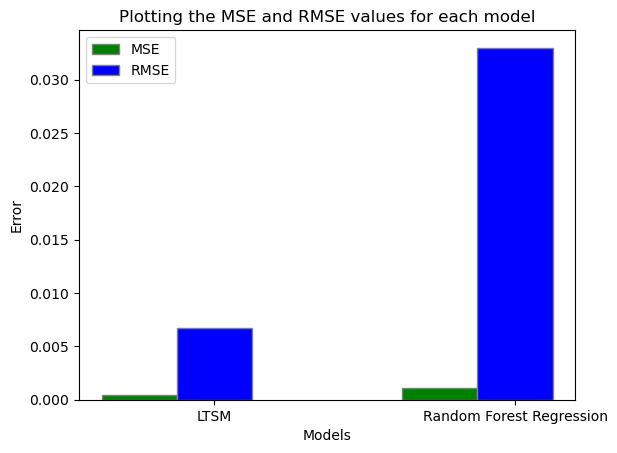

In [14]:
mse = lstmModel.evaluate(X_test, Y_test)
rmse = np.sqrt(mse)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

# # Save MSE and RMSE values to a file
# with open('mse_rmse_values.txt', 'a') as file:
#     file.write(f'{mse},{rmse},LTSM\n')

# Read the saved MSE and RMSE values from the file
mse_values = []
rmse_values = []
models = []

with open('mse_rmse_values.txt', 'r') as file:
    for line in file:
        mse, rmse, model = line.strip().split(',')
        mse_values.append(float(mse))
        rmse_values.append(float(rmse))
        models.append(model)

# Plotting the MSE and RMSE values
# creating the bar plot
barWidth = 0.25

# Set position of bar on X axis
br1 = np.arange(len(mse_values))
br2 = [x + barWidth for x in br1]

plt.bar(br1, mse_values, color ='g', width = barWidth, edgecolor ='grey', label ='MSE')
plt.bar(br2, rmse_values, color ='b', width = barWidth,edgecolor ='grey', label ='RMSE')

plt.xlabel('Models')
plt.ylabel('Error')
plt.xticks([r + barWidth for r in range(len(models))], models)
plt.title('Plotting the MSE and RMSE values for each model')
plt.legend()
plt.show()

Save Model

In [ ]:
print("Saving Model")
lstmModel.save('100-100-100.h5')
print("Model Saved")

Plotting

In [ ]:
Y_test = scale.inverse_transform(Y_test)

In [ ]:
print(Y_test)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(Y_test[:,0], Y_test[:,1], Y_test[:,2], color='b', label='Actual')
ax.scatter(Y_pred[:,0], Y_pred[:,1], Y_pred[:,2], color='r',label='Predicted')
plt.show()

Recursive Prediction

In [7]:
def recurcivePredict(dataArr,predictedTrajectory):
  predictedCord = lstmModel.predict(dataArr)
  #print(predictedCord[0][2])
  if predictedCord[0][2] > 0 and predictedCord[0][0] > dataArr[0][14][0]:
    dataArr = np.delete(dataArr,0,1)
    dataArr = np.append(dataArr,[predictedCord],axis=1)
    predictedTrajectory = np.append(predictedTrajectory,[predictedCord],axis=1)
    return recurcivePredict(dataArr,predictedTrajectory)
  else:
    return predictedTrajectory

# def recurcivePredict(dataArr):
#   predictedCord = lstmModel.predict(dataArr)
#   print(predictedCord[0][2])
#   if predictedCord[0][2] > 0 and predictedCord[0][0] > dataArr[0][-1][0]:
#     dataArr = np.append(dataArr,[predictedCord],axis=1)
#     return recurcivePredict(dataArr)
#   else:
#     return dataArr

# initialInput = []
# initialInput.append(testdata.iloc[40:55][['X', 'Y', 'Z']].values)
# initialInput = np.array(initialInput)


# trajectory = recurcivePredict(initialInput,initialInput)
# print(trajectory)



Predict Trajectory

153
1/1 [==============================] - 0s 31ms/step


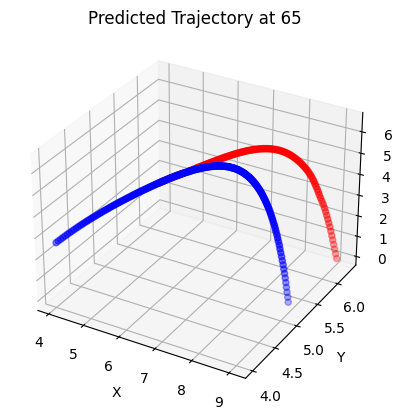

1/1 [==============================] - 0s 16ms/step


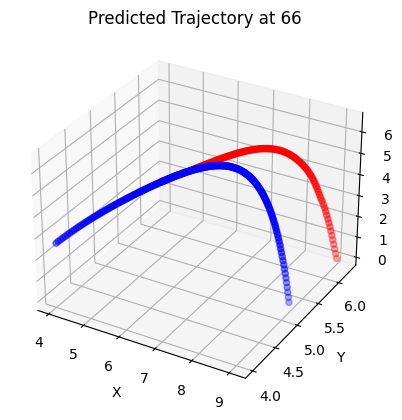

1/1 [==============================] - 0s 16ms/step


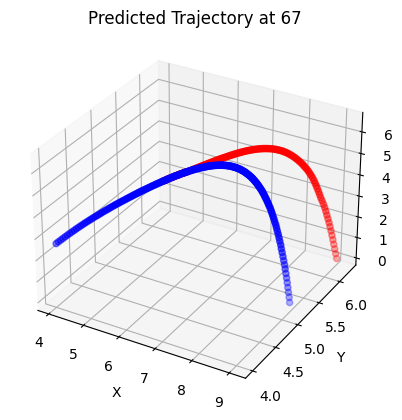

1/1 [==============================] - 0s 31ms/step


KeyboardInterrupt: 

In [10]:
def predictTrajectory(startIndex, shotid):
  testinput = []

  testinput.append(data.loc[data['SHOT_ID'] == shotid][['X', 'Y', 'Z']].values)
  count = len(testinput[0])
  print(count)
  for i in range(startIndex,count):
    testinput = np.array(testinput)
    testdata = [testinput[0,:][i-15:i]]
    testdata = np.array(testdata)
    trajectory = recurcivePredict(testdata,testdata)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Predicted Trajectory at {i}")
    ax.scatter(testinput[0,:,0], testinput[0,:,1], testinput[0,:,2], color='b', label='Actual')
    ax.scatter(trajectory[0,:,0], trajectory[0,:,1], trajectory[0,:,2], color='r',label='Predicted')
    plt.show()
    
    time.sleep(5)

predictTrajectory(65,417)

Robot Movement

In [8]:
def robotMovement(current,predicted):
    robotspeed = 0.02
    distCtoP = np.sqrt(((predicted[0]-current[0])**2)+((predicted[1]-current[1])**2))
    distCovered = robotspeed/distCtoP
    if(distCovered >= 1):
        return [predicted[0],predicted[1],1.15] #middle of robot service area, z = 1.15
    else:
        newX = ((1-distCovered)*current[0]) + (distCovered*predicted[0])
        newY = ((1-distCovered)*current[1]) + (distCovered*predicted[1])
        return[newX,newY,1.15] #middle of robot service area, z = 1.15

Predict Trajectory with robot and gif output

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step
115


C:\Users\ngshi\AppData\Local\Temp\ipykernel_3020\2941409089.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  distCovered = robotspeed/distCtoP
C:\Users\ngshi\AppData\Local\Temp\ipykernel_3020\133218787.py:100: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


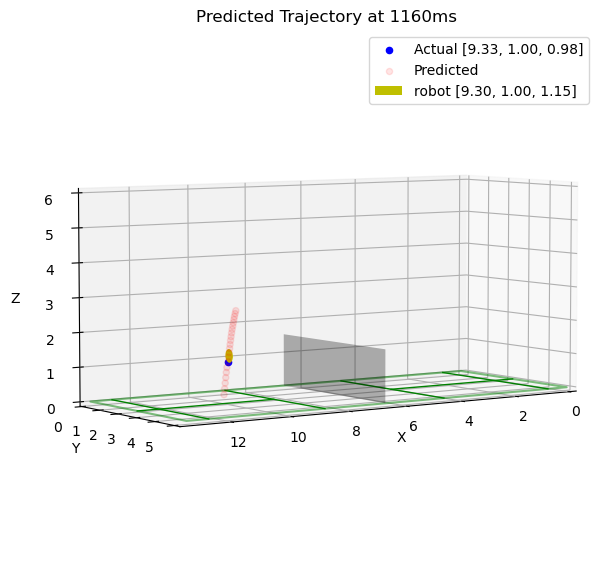

In [9]:
def predictTrajectory(startIndex, shotid):
    testinput = []

    testinput.append(data.loc[data['SHOT_ID'] == shotid][['X', 'Y', 'Z']].values)
    count = len(testinput[0])
    robotPosition = [10.5,2.59,1.15] #position where robot start, middle of robot service area, z = 1.15
    global frames
    frames = []  # List to store animation frames
    
    fig = plt.figure(figsize=(8,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([13.4,5.18,6])
    ax.view_init(azim=55,elev=5)
    testinput = np.array(testinput)
    end = np.where((testinput[0,:,2]<1.0))
    for i in range(startIndex, count):
        testdata = [testinput[0, :][i - 14:i+1]]
        testdata = np.array(testdata)
        trajectory = recurcivePredict(testdata, testdata)

        #check where robot should move
        arr = trajectory[0, :, 2]
        x=np.where((arr<=1.3) & (arr>=1.0)) # height range = height+0.1, min height= 3/4 of racket's "web" (120-(28*0.75))

        predictedshot = trajectory[0][x[0]] # the point that robot should move toward, incase of many point, select the first
        robotPosition = robotMovement(robotPosition,predictedshot[0])
        
        ax.cla()  # Clear the axis at each iteration
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
        #  Plot the badminton court lines
        court_x = np.array([0, 13.4, 13.4, 0, 0])
        court_y = np.array([0, 0, 5.18, 5.18, 0])
        ax.plot(court_x, court_y, color='green', alpha=0.5)

        mid1_x = np.array([0, 4.6])  # X-coordinates of top middle centre line
        mid1_y = np.array([2.59, 2.59])  # Y-coordinates of top middle centre line
        ax.plot(mid1_x, mid1_y, color='green', linewidth=1)
        
        mid2_x = np.array([8.8, 13.4])  # X-coordinates of bottom middle centre line
        mid2_y = np.array([2.59, 2.59])  # Y-coordinates of bottom middle centre line
        ax.plot(mid2_x, mid2_y, color='green', linewidth=1)
        
        short1_x = np.array([4.6, 4.6])  # X-coordinates of top short service line
        short1_y = np.array([0, 5.18])  # Y-coordinates of top short service line
        ax.plot(short1_x, short1_y, color='green', linewidth=1)
        
        short2_x = np.array([8.8, 8.8])  # X-coordinates of bottom short service line
        short2_y = np.array([0, 5.18])  # Y-coordinates of bottom short service line
        ax.plot(short2_x, short2_y, color='green', linewidth=1)
        
        long1_x = np.array([0.72, 0.72])  # X-coordinates of top long service line
        long1_y = np.array([0, 5.18])  # Y-coordinates of top long service line
        ax.plot(long1_x, long1_y, color='green', linewidth=1)
        
        long2_x = np.array([12.68, 12.68])  # X-coordinates of bottom long service line
        long2_y = np.array([0, 5.18])  # Y-coordinates of bottom long service line
        ax.plot(long2_x, long2_y, color='green', linewidth=1)
        
        # Create the net as a mesh
        net_height = np.array([0,1.55,1.55,0])  # Height of the net from the ground
        net_x = np.array([6.7,6.7,6.7,6.7])  # X-coordinates of net vertices
        net_y = np.array([0,0,5.18,5.18])  # Y-coordinates of net vertices
        verts = [list(zip(net_x,net_y,net_height))]
        ax.add_collection3d(art3d.Poly3DCollection(verts, facecolors='black',alpha=0.3))
    
        ax.set_xlim(0, 13.4)
        ax.set_ylim(0, 5.18)
        ax.set_zlim(0, 6)
        
        ax.set_title(f"Predicted Trajectory at {(i+1)*10}ms")
        ax.scatter(testinput[0, i, 0], testinput[0, i, 1], testinput[0, i, 2], color='b', label='Actual [{0:.2f}, {1:.2f}, {2:.2f}]'.format(testinput[0, i, 0], testinput[0, i, 1], testinput[0, i, 2]))
        ax.scatter(trajectory[0, :, 0], trajectory[0, :, 1], trajectory[0, :, 2], color='r', label='Predicted', alpha=0.1)
        
        #plot robot
        #make robot a flat circle
        # the circle where x is position and y,z is the racket's area.
        # 1/4 of racket is 28/4 = 7cm. hence racket's area is cirle with radius of 0.035m. !!is to smalll to be seen in plot
        pCircle = Circle((robotPosition[1], robotPosition[2]), 0.2, facecolor = 'y',label='robot [{0:.2f}, {1:.2f}, {2:.2f}]'
                         .format(robotPosition[0], robotPosition[1], robotPosition[2]))
        ax.add_patch(pCircle)
        art3d.pathpatch_2d_to_3d(pCircle, z=robotPosition[0], zdir="x")
        ax.legend()

        # Save the current figure as an image
        fig.savefig(f"frame_{i}.png")
        # Append the image filename to the frames list
        frames.append(f"frame_{i}.png")

        if(i == end[0][0]):
            print(end[0][0])
            break
            
    # Create the GIF animation using the frames
    with imageio.get_writer("animation.gif", mode='I', duration=0.1) as writer:
        for filename in frames:
            image = imageio.imread(filename)
            writer.append_data(image)

predictTrajectory(15, 1)

To Delete the generated png file

In [10]:
# To delete the png file generated for gif, use with precautions
import glob
import os

# Define the directory path
directory_path = ""

# Find all .png files in the directory
png_files = glob.glob(os.path.join(directory_path, "*.png"))

# Delete each .png file
for file_path in png_files:
    os.remove(file_path)